## Original Embedding

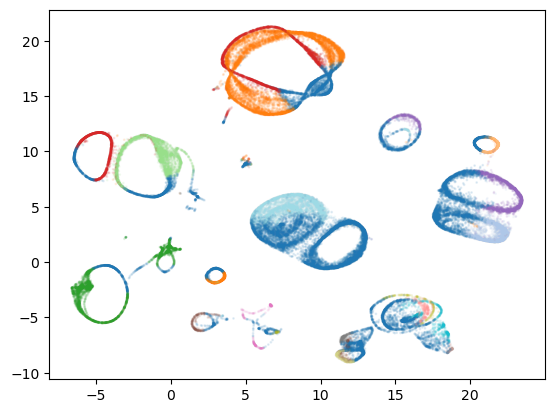

In [1]:
import numpy as np
import matplotlib.pyplot as plt


f = np.load("files/llb16_raw_false.npz")

embedding = f["embedding_outputs"][:50000]
neural_states = f["predictions"][:50000]
ground_truth = f["ground_truth_labels"][:50000]
hdbscan_labels = f["hdbscan_labels"][:50000]

plt.scatter(embedding[:, 0], embedding[:, 1], c=ground_truth, cmap="tab20", alpha=0.1, s=1)
plt.scatter(embedding[:, 0], embedding[:, 1], c=hdbscan_labels, cmap="tab20", alpha=0.1, s=1)


## Balanced By Ground Truth Labels Weird Eucledian Distance Collapse To Point Wise

In [ ]:
# # balanced-UMAP: fit on an equal-sized sample from every class, then
# # project the full set.  reproducible via rng seed.

# import numpy as np
# import umap
# import matplotlib.pyplot as plt

# # --- load (you already have this) ------------------------------------------------
# f = np.load("files/llb16_raw_false.npz")
# embedding      = f["embedding_outputs"][:50_000]   # (N, D)
# ground_truth   = f["ground_truth_labels"][:50_000] # (N,)

# # --- choose the reference label set ---------------------------------------------
# # if label 0 is “silence” and you’d rather ignore it, flip the mask below to False
# include_zero = True
# label_mask   = (ground_truth != 0) | include_zero

# labels        = ground_truth[label_mask]
# embeddings_ok = embedding[label_mask]

# uniq, counts  = np.unique(labels, return_counts=True)
# k_min         = counts.min()  # size of rarest class

# rng = np.random.default_rng(42)
# balanced_idx = np.hstack([
#     rng.choice(np.where(labels == lbl)[0], size=k_min, replace=False)
#     for lbl in uniq
# ])

# X_balanced = embeddings_ok[balanced_idx]

# # --- fit UMAP on the balanced subset -------------------------------------------
# umap_model = umap.UMAP(
#     n_neighbors=200,
#     min_dist=0.1,
#     metric="euclidean",
#     random_state=42
# ).fit(X_balanced)

# # --- project *all* embeddings ---------------------------------------------------
# full_embedding_2d = umap_model.transform(embedding)

# # quick sanity plot
# plt.figure(figsize=(6,6))
# plt.scatter(full_embedding_2d[:,0], full_embedding_2d[:,1],
#             c=ground_truth, cmap="tab20", s=1, alpha=0.1)
# plt.title("UMAP: balanced ­fit, full transform")
# plt.axis("off")
# plt.tight_layout()
# plt.show()


## Balance By HDBSCAN Labels

[218998  44592   6122  11116  13750  28450  88878  18524  27017  57252
  28883  95351   6980   5183   7511 114526  76879  68423  69076]


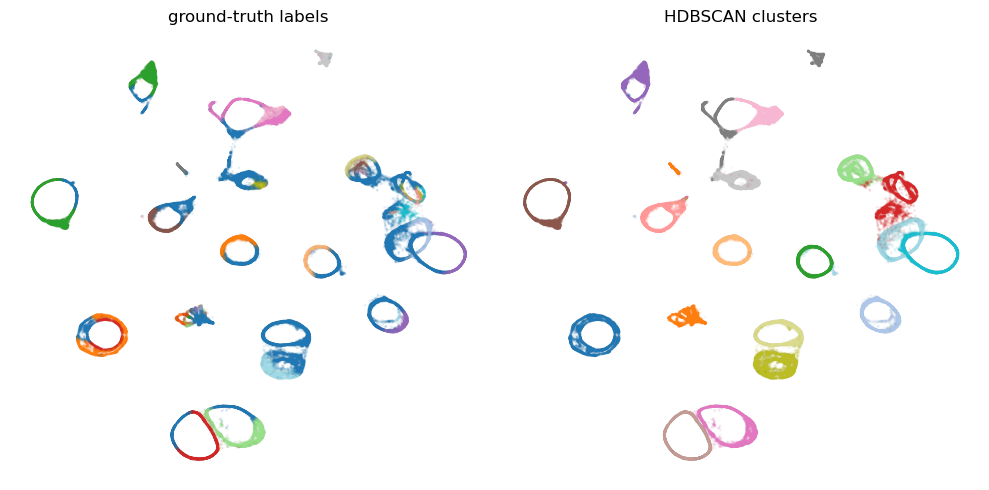

In [5]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.manifold import trustworthiness
from sklearn.metrics import silhouette_score

# ── load ----------------------------------------------------------------------
f              = np.load("files/llb16_raw_false.npz")
X              = f["predictions"]          # (N, D)
y_true         = f["ground_truth_labels"]
hdb_labels     = f["hdbscan_labels"]       # from your first pass

# ── build a BALANCED core set, one quota per HDBSCAN cluster -------------------
mask_clusters  = hdb_labels != -1
clusters, cnts = np.unique(hdb_labels[mask_clusters], return_counts=True)

print(cnts)

quota          = cnts.min()                # rarest cluster size
rng            = np.random.default_rng(42)

core_idx = np.hstack([
    rng.choice(np.where(hdb_labels == c)[0], size=quota, replace=False)
    for c in clusters
])

# (optional) randomize order inside the core set
perm           = rng.permutation(len(core_idx))
core_idx       = core_idx[perm]

# ── slice *everything* with the same indices ----------------------------------
X_core         = X[core_idx]
y_core         = y_true[core_idx]
hdb_core       = hdb_labels[core_idx]

# ── keep only the first 50 000 if desired -------------------------------------
X_core   = X_core[:100_000]
y_core   = y_core[:100_000]
hdb_core = hdb_core[:100_000]

# ── fit UMAP on the balanced core ---------------------------------------------
x = umap.UMAP(
        n_neighbors=200,
        min_dist=0.1,
        metric="cosine"
    ).fit_transform(X_core)

# ── viz -----------------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x[:, 0], x[:, 1], c=y_core,  cmap="tab20", s=1, alpha=0.08)
ax[0].set_title("ground-truth labels")
ax[0].axis("off")

ax[1].scatter(x[:, 0], x[:, 1], c=hdb_core, cmap="tab20", s=1, alpha=0.08)
ax[1].set_title("HDBSCAN clusters")
ax[1].axis("off")

plt.tight_layout()
plt.show()


# random 50 k + inverse-frequency sample_weight

/home/george-vengrovski/anaconda3/envs/tweetybert/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


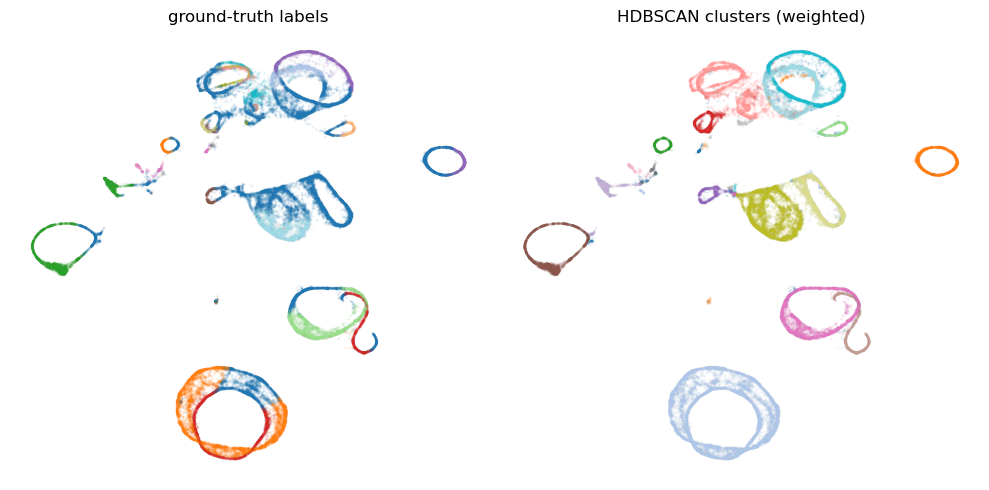

In [3]:
import numpy as np
import umap
import matplotlib.pyplot as plt

# ── load ───────────────────────────────────────────────────────────────────────
f          = np.load("files/llb16_raw_false.npz")
X          = f["predictions"]
y_true     = f["ground_truth_labels"]
hdb_labels = f["hdbscan_labels"]

rng        = np.random.default_rng(42)

# ── draw a random 50 k subset ─────────────────────────────────────────────────
idx        = rng.choice(len(X), size=50_000, replace=False)
X_sub      = X[idx]
y_sub      = y_true[idx]
hdb_sub    = hdb_labels[idx]

# ── inverse-frequency weights *per HDBSCAN cluster* ───────────────────────────
shift_full = hdb_labels + 1          # map −1→0 so bincount works
freq_full  = np.bincount(shift_full) # global cluster frequencies

shift_sub  = hdb_sub + 1
weights    = 1.0 / freq_full[shift_sub]
weights   /= weights.mean()          # normalise around 1

# optional: down-weight noise points (cluster −1)
# weights[shift_sub == 0] *= 0.1

# ── UMAP ──────────────────────────────────────────────────────────────────────
u = umap.UMAP(
        n_neighbors=200,
        min_dist=0.1,
        metric="cosine",
        random_state=42
    )
x = u.fit_transform(X_sub, sample_weight=weights)

# ── viz ───────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x[:, 0], x[:, 1], c=y_sub,  cmap="tab20", s=1, alpha=0.08)
ax[0].set_title("ground-truth labels")
ax[0].axis("off")

ax[1].scatter(x[:, 0], x[:, 1], c=hdb_sub, cmap="tab20", s=1, alpha=0.08)
ax[1].set_title("HDBSCAN clusters (weighted)")
ax[1].axis("off")

plt.tight_layout()
plt.show()

oversample to a perfectly balanced 50 k

/home/george-vengrovski/anaconda3/envs/tweetybert/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


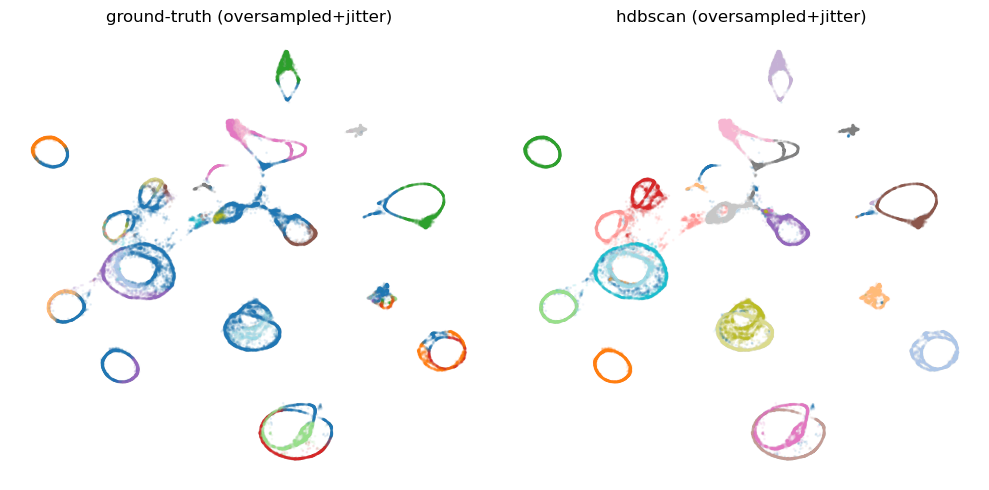

In [4]:
import numpy as np, umap, matplotlib.pyplot as plt
from math import ceil

# ── load ───────────────────────────────────────────────────────────────────────
f          = np.load("files/llb16_raw_false.npz")
X          = f["predictions"]
y_true     = f["ground_truth_labels"]
hdb_labels = f["hdbscan_labels"]

rng        = np.random.default_rng(42)

# ── oversample every HDB cluster to equal quota ───────────────────────────────
labels     = np.unique(hdb_labels)
n_classes  = len(labels)
per_class  = ceil(50_000 / n_classes)        # target rows per cluster

sel_X, sel_y, sel_hdb = [], [], []

for lbl in labels:
    pool = np.where(hdb_labels == lbl)[0]
    picks = rng.choice(pool, size=per_class, replace=len(pool) < per_class)

    # grab the originals
    sel_X.append(X[picks])
    sel_y.append(y_true[picks])
    sel_hdb.append(np.full(per_class, lbl))

# concat and trim back to 50 k
X_bal   = np.vstack(sel_X)[:50_000]
y_bal   = np.hstack(sel_y)[:50_000]
hdb_bal = np.hstack(sel_hdb)[:50_000]

# ── micro-jitter duplicates so they’re not exact copies ───────────────────────
eps     = 1e-3 * X.std(axis=0)               # per-dim scale
X_bal   = X_bal + rng.normal(0, eps, size=X_bal.shape)

# ── UMAP ──────────────────────────────────────────────────────────────────────
u       = umap.UMAP(
            n_neighbors=200,
            min_dist=0.1,
            metric="cosine",
            random_state=42
        )
x       = u.fit_transform(X_bal)

# ── viz ───────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x[:,0], x[:,1], c=y_bal,  cmap="tab20", s=1, alpha=0.08)
ax[0].set_title("ground-truth (oversampled+jitter)")
ax[0].axis("off")

ax[1].scatter(x[:,0], x[:,1], c=hdb_bal, cmap="tab20", s=1, alpha=0.08)
ax[1].set_title("hdbscan (oversampled+jitter)")
ax[1].axis("off")

plt.tight_layout(); plt.show()